In [1]:
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://mirrors.estointernet.in/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz -P /content/drive/MyDrive # link wrong in blog
!tar xf /content/drive/Shareddrives/DA231-2021-Aug-Public/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

Mounted at /content/drive


In [2]:
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .config('spark.driver.memory', '4g')\
         .config('spark.executor.memory', '4g')\
         .config('spark.python.worker.memory', '2g')\
         .getOrCreate()
spark

from pyspark import SparkContext, SparkConf
import sys
import json
#from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql.types import *
#from pyspark.sql.functions import *
import pyspark.sql.functions as F
sc = SparkContext.getOrCreate()

In [3]:
# list of 182 users
num_enabled_users = 2
user_list = list(range(num_enabled_users))
if (128 in user_list):
  user_list.remove(128)

# define schema
schema = StructType([
    StructField("Lat", StringType(), True), StructField("Long", StringType(), True), StructField("Zero", StringType(), True), StructField("Alt", StringType(), True), StructField("DayCount", StringType(), True), StructField("Date", StringType(), True), StructField("Time", StringType(), True), StructField("UserId", StringType(), True)
])

# empty combined df
df_combine = spark.createDataFrame([], schema)


for ii in range(len(user_list)):
  folder_name = "{0:0=3d}".format(user_list[ii])
  data_user = "/content/drive/MyDrive/DataEngAtScaleProject/GeolifeTrajectories/Data/"+folder_name+"/Trajectory/*.plt"
  #data_user = "/content/drive/MyDrive/DataEngAtScaleProject/GeolifeTrajectories/Data/000/Trajectory/20081023025304.plt"
  #data000 = "/content/drive/MyDrive/DataEngAtScaleProject/GeolifeTrajectories/Data/000/Trajectory/20081023025304.plt"

  # read as rdd
  read_user = sc.textFile(data_user)

  # remove header lines and split the values
  rdd_user = read_user.filter(lambda x: len(x)>40).map(lambda l :  l.split(","))

  # convert rdd to dataframe
  df_user = spark.createDataFrame(rdd_user).toDF("Lat","Long","Zero","Alt","DayCount","Date","Time").withColumn("UserId",F.lit(folder_name)).cache()
  df_combine = df_combine.union(df_user).cache()

df_combine = df_combine.select(F.col("Lat").cast(DoubleType()).alias("Lat"), F.col("Long").cast(DoubleType()).alias("Long"), F.col("Alt").cast(IntegerType()).alias("Alt"), F.col("DayCount").cast(DoubleType()).alias("DayCount"), F.col("Date").cast(DateType()).alias("Date"), "Time", "UserId").cache()

print(df_combine.take(5))
#print(df_combine.count())

[Row(Lat=40.008312, Long=116.320953, Alt=491, DayCount=39765.157037037, Date=datetime.date(2008, 11, 13), Time='03:46:08', UserId='000'), Row(Lat=40.00843, Long=116.321055, Alt=492, DayCount=39765.1570949074, Date=datetime.date(2008, 11, 13), Time='03:46:13', UserId='000'), Row(Lat=40.00849, Long=116.321025, Alt=491, DayCount=39765.1571527778, Date=datetime.date(2008, 11, 13), Time='03:46:18', UserId='000'), Row(Lat=40.008486, Long=116.320962, Alt=491, DayCount=39765.1572106481, Date=datetime.date(2008, 11, 13), Time='03:46:23', UserId='000'), Row(Lat=40.008446, Long=116.320811, Alt=491, DayCount=39765.1572685185, Date=datetime.date(2008, 11, 13), Time='03:46:28', UserId='000')]


In [ ]:
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

!pip install haversine

In [5]:
from pyspark.sql.window import Window
from haversine import haversine
import pandas as pd
from pyspark.sql.functions import pandas_udf

from datetime import datetime, date, time
import pyspark.sql.functions as F

@pandas_udf("double")
def haversine_udf(lat: pd.Series, lon: pd.Series) -> float:
    if len(lat.tolist()) == 2:
      return haversine((lat.tolist()[0], lon.to_list()[0]), 
                       (lat.to_list()[1], lon.to_list()[1]))
    else:
      return -1

@pandas_udf("double")
def diffce_udf(times: pd.Series) -> float:
  if len(times.tolist()) == 2:
      time1 = time.fromisoformat(times.tolist()[1])
      time0 = time.fromisoformat(times.to_list()[0])
      return (datetime.combine(date.min, time1) - datetime.combine(date.min, time0)).total_seconds()/3600
  else:
      return -1

w = Window.partitionBy("UserId", "Date").orderBy("Time").rowsBetween(-1, 0)
df_speed = df_combine.withColumn("distance", haversine_udf("Lat", "Long").over(w)) \
            .withColumn("elapsed_time", diffce_udf("Time").over(w)) \
            .withColumn("speed", F.col("distance")/F.col("elapsed_time")) \
            .filter(F.col("distance") != -1).cache()

print(df_speed.take(5))

[Row(Lat=39.984198, Long=116.319322, Alt=492, DayCount=39744.2452083333, Date=datetime.date(2008, 10, 23), Time='05:53:06', UserId='001', distance=0.013690172043988575, elapsed_time=0.0002777777777777778, speed=49.284619358358874), Row(Lat=39.984224, Long=116.319402, Alt=492, DayCount=39744.2452662037, Date=datetime.date(2008, 10, 23), Time='05:53:11', UserId='001', distance=0.007403798093079055, elapsed_time=0.001388888888888889, speed=5.33073462701692), Row(Lat=39.984211, Long=116.319389, Alt=492, DayCount=39744.2453240741, Date=datetime.date(2008, 10, 23), Time='05:53:16', UserId='001', distance=0.0018210859091874253, elapsed_time=0.001388888888888889, speed=1.311181854614946), Row(Lat=39.984217, Long=116.319422, Alt=491, DayCount=39744.2453819444, Date=datetime.date(2008, 10, 23), Time='05:53:21', UserId='001', distance=0.002889675178932522, elapsed_time=0.001388888888888889, speed=2.080566128831416), Row(Lat=39.98471, Long=116.319865, Alt=320, DayCount=39744.2454050926, Date=datet

[Row(Lat=39.984198, Long=116.319322, Alt=492, DayCount=39744.2452083333, Date=datetime.date(2008, 10, 23), Time='05:53:06', UserId='001', distance=0.013690172043988575, elapsed_time=0.0002777777777777778, speed=49.284619358358874, hour=5), Row(Lat=39.984224, Long=116.319402, Alt=492, DayCount=39744.2452662037, Date=datetime.date(2008, 10, 23), Time='05:53:11', UserId='001', distance=0.007403798093079055, elapsed_time=0.001388888888888889, speed=5.33073462701692, hour=5), Row(Lat=39.984211, Long=116.319389, Alt=492, DayCount=39744.2453240741, Date=datetime.date(2008, 10, 23), Time='05:53:16', UserId='001', distance=0.0018210859091874253, elapsed_time=0.001388888888888889, speed=1.311181854614946, hour=5), Row(Lat=39.984217, Long=116.319422, Alt=491, DayCount=39744.2453819444, Date=datetime.date(2008, 10, 23), Time='05:53:21', UserId='001', distance=0.002889675178932522, elapsed_time=0.001388888888888889, speed=2.080566128831416, hour=5), Row(Lat=39.984674, Long=116.31981, Alt=325, DayCo

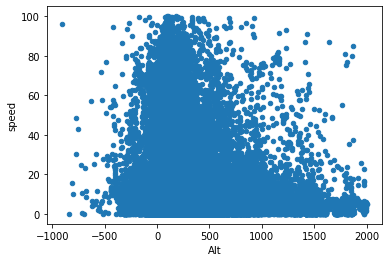

In [8]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import Evaluator

class MAPEEvaluator(Evaluator): # TODO: Fix class inheritance
  def __init__(self, predictionCol="prediction", labelCol="label"):
    self.predictionCol = predictionCol
    self.labelCol = labelCol

  def _evaluate(self, dataset):
    return evaluate(dataset, predictionCol, labelCol)

  def evaluate(dataset, predictionCol="prediction", labelCol="label"): # FIXME
    mapeDF = dataset.withColumn("ape", (F.col(predictionCol)-F.col(labelCol)) / F.col(labelCol))  \
      .groupBy().avg("ape").select("avg(ape)").withColumnRenamed("avg(ape)", "mape")
    r = mapeDF.collect()
    answer = [(row.mape) for row in r]
    return answer[0] * 100


df_speed = df_speed.filter(df_speed.Alt.isNotNull() & (df_speed.speed < 100) & (df_speed.Alt > -1000) & (df_speed.Alt < 2000)).withColumn("hour", F.col("Time").substr(0,2).cast(IntegerType()))
df_speed = df_speed.filter((df_speed.Lat > 39) & (df_speed.Lat < 41) & (df_speed.Long > 115) & (df_speed.Long < 117))
print(df_speed.take(5))

plottable = df_speed.toPandas()
plottable.plot(x = "Alt", y = "speed", kind = 'scatter')


toPredict = "speed"

vectorAssembler = VectorAssembler(inputCols=["Alt"], outputCol="features")
regressor = LinearRegression(featuresCol='features', labelCol=toPredict)
pipeline = Pipeline(stages=[vectorAssembler, regressor])


inputTrainDF, inputTestDF = df_speed.randomSplit([0.8, 0.2], seed=10)
print(inputTrainDF.take(5))
print(inputTestDF.take(5))

model = pipeline.fit(inputTrainDF)

predDF = model.transform(inputTestDF)

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=toPredict)

mae = evaluator.evaluate(predDF, {evaluator.metricName: "mae"})
rmse = evaluator.evaluate(predDF, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(predDF, {evaluator.metricName: "r2"})
mape = MAPEEvaluator.evaluate(predDF, predictionCol="prediction", labelCol=toPredict)

print(f"answer2)-  {r2}, {mape}, {mae}, {rmse}")